In [29]:
from gpt3forchem.data import get_polymer_data
from gpt3forchem.input import create_single_property_inverse_polymer_prompts
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction, extract_inverse_prediction

from gpt3forchem.output import polymer_string2performance

import matplotlib.pyplot as plt

import time

In [4]:
df = get_polymer_data()

In [7]:
df['deltaGmin_rounded'] = df['deltaGmin'].round(2)

In [13]:
prompts = create_single_property_inverse_polymer_prompts(df, 'deltaGmin_rounded', {'deltaGmin_rounded': 'adsorption energy'}, encode_value=False)

In [14]:
prompts['target'] = df['deltaGmin_rounded']

(array([ 26., 148., 299., 490., 592., 575., 499., 326., 141.,  29.]),
 array([-20.67 , -18.907, -17.144, -15.381, -13.618, -11.855, -10.092,
         -8.329,  -6.566,  -4.803,  -3.04 ]),
 <BarContainer object of 10 artists>)

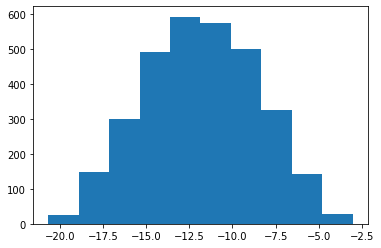

In [16]:
plt.hist(df['deltaGmin_rounded'])

In [18]:
df_train = prompts[prompts['target'] < -7.5]
df_test = prompts[prompts['target'] >= -7.5]

In [20]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_mof_h2o.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_mof_h2o.jsonl"

df_train.to_json(train_filename, orient="records", lines=True)
df_test.to_json(valid_filename, orient="records", lines=True)


In [21]:
fine_tune(train_filename, valid_filename, "ada")

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-11-18-17-03-36'

In [24]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-11-18-17-03-36', df_test, max_tokens=300)

In [27]:
preds = [extract_inverse_prediction(completions, i) for i, completion in enumerate(completions['choices'])]   

In [36]:
predictions = [polymer_string2performance(pred)['prediction'][0] for pred in preds]

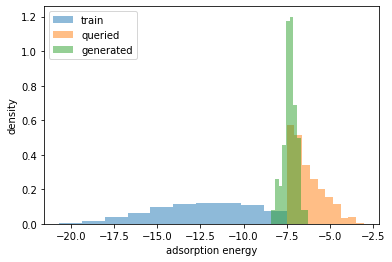

In [48]:
plt.hist(df_train['target'], alpha=0.5, label='train', density=True)
plt.hist(df_test['target'], alpha=0.5, density=True, label='queried')
plt.hist(predictions, alpha=0.5, density=True, label='generated')
plt.legend()
plt.xlabel('adsorption energy')
plt.ylabel('density')
plt.savefig('ads_energy_dist.pdf', bbox_inches='tight')

# Now do query specifycally very low ones 

In [73]:
df_test['prompt'] = 'what is a polymer with larger smaller than -20 adsorption energy?###'

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_86446/3327947560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prompt'] = 'what is a polymer with larger smaller than -20 adsorption energy?###'


In [74]:
completions_very_low = query_gpt3('ada:ft-lsmoepfl-2022-11-18-17-03-36', df_test.iloc[:50], max_tokens=300)

In [78]:
preds_very_low = [extract_inverse_prediction(completions_very_low, i) for i, completion in enumerate(completions_very_low['choices'])]   

In [79]:
predictions_very_low = []

for pred in preds_very_low:
    try:
        predictions_very_low.append(polymer_string2performance(pred)['prediction'][0])
    except Exception:
        pass

(array([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.]),
 array([-8.793916 , -8.693915 , -8.593916 , -8.493916 , -8.393916 ,
        -8.293916 , -8.193915 , -8.093916 , -7.9939156, -7.8939157,
        -7.7939157], dtype=float32),
 <BarContainer object of 10 artists>)

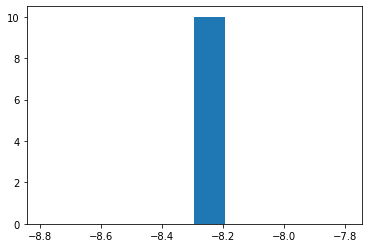

In [80]:
plt.hist(predictions_very_low)